# Задача 1. Compressed Sensing

In [112]:
!mkdir data
!wget https://github.com/DimaLishudi/fmatcomp/raw/main/tune.wav      -O data/tune.wav
!wget https://github.com/DimaLishudi/fmatcomp/raw/main/crater.png    -O data/crater.png
!wget https://github.com/DimaLishudi/fmatcomp/raw/main/cameraman.tif -O data/cameraman.tif

mkdir: невозможно создать каталог «data»: Файл существует
--2023-04-09 23:16:42--  https://github.com/DimaLishudi/fmatcomp/raw/main/tune.wav
Распознаётся github.com (github.com)… 140.82.121.3
Подключение к github.com (github.com)|140.82.121.3|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://raw.githubusercontent.com/DimaLishudi/fmatcomp/main/tune.wav [переход]
--2023-04-09 23:16:42--  https://raw.githubusercontent.com/DimaLishudi/fmatcomp/main/tune.wav
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 176458 (172K) [audio/wav]
Сохранение в: ‘data/tune.wav’

data/tune.wav       100%[===================>] 172,32K  --.-KB/s    за 0,09s   

2023-04-09 23:16:43 (1,82 MB/s) - ‘data/tune.wav’ сохранён [1764

В этом задании мы реализуем метод Compressed Sensing для восстановления сигнала, в котором большая часть значений отсутствует. Можете прочитать подробнее в [википедии](https://en.wikipedia.org/wiki/Compressed_sensing) или посмотреть серию коротких видео [1,](https://www.youtube.com/watch?v=EOYaKcjFa3o&list=PLVnEmTOBCgy0QFxU5kKNFOy1CIwCieSDl) [2,](https://www.youtube.com/watch?v=SbU1pahbbkc) [3.](https://www.youtube.com/watch?v=inr-nGnVc0k)

In [113]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.sparse as sparse
import scipy.sparse.linalg as spla

from IPython import display
from scipy.io.wavfile import read as read_audio

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

### a.Дискретное косинусное преобразование

**Замечание:** Если вы не полностью выполните следующие два пункта, то это не повлияет на выполнение оставшейся части задачи. В следующих разделах нужно использовать библиотечные `scipy.fft.dct` и `scipy.fft.idct` с параметрами `type=2`, `norm="ortho"`. **В этом разделе их использовать запрещено!**

In [114]:
from scipy.fft import dct, idct

Для работы с аудиодорожками зачастую используют дискретное преобразование Фурье (ДПФ) для перехода от времени к частотам. Однако нам будет удобнее работать с его вещественнозначным аналогом - дискретным косинусным преобразованием (ДКП). Именно это преобразование лежит в основе алгоритма сжатия JPEG.

В этом задании нужно будет реализовать ДКП типа II, переводящее вектор $x \in \mathbb{R}^n$ в вектор $s' \in \mathbb{R}^n$ по правилу:

$$
    s_p = 2\sum_{q=0}^{n-1} x_q \cos \left(\frac{\pi}{2n}p(2q + 1)\right)
$$

То есть:

$$
    s = \hat{D}_n x
$$

Где матрица ДКП $\hat{D}_n$ определяется как:

\
$$
    \hat{D}_n = 2\begin{bmatrix}
        1 & 1 & 1 & \ldots & 1\\
        \cos \left(\frac{\pi}{2n} \cdot 1\right) & \cos \left(\frac{\pi}{2n} \cdot 3\right) & \cos \left(\frac{\pi}{2n} \cdot 5\right) & \ldots & \cos \left(\frac{\pi}{2n} \cdot (2n-1)\right)\\
        \cos \left(2\frac{\pi}{2n} \cdot 1\right) & \cos \left(2\frac{\pi}{2n} \cdot 3\right) & \cos \left(2\frac{\pi}{2n} \cdot 5\right) & \ldots & \cos \left(2\frac{\pi}{2n} \cdot (2n-1)\right)\\
        \vdots & \vdots & \vdots & \ddots & \vdots\\
        \cos \left((n-1)\frac{\pi}{2n} \cdot 1\right) & \cos \left((n-1)\frac{\pi}{2n} \cdot 3\right) & \cos \left((n-1)\frac{\pi}{2n} \cdot 5\right) & \ldots & \cos \left((n-1)\frac{\pi}{2n} \cdot (2n-1)\right)\\
    \end{bmatrix}
$$
\
Несмотря на то, что такое преобразование легко выражается матричным умножением, его сложность составляет $O(n^2)$. Тем не менее, используя БПФ, это преобразование можно выполнить за $O(n \log n)$.


1. Покажите, что ДКП для вектора длины $n$ выражается с помощью сдвинутого БПФ для вектора $\hat{x} \in \mathbb{R}^{2n}$:

\
$$
\hat{x} = \begin{bmatrix}
        x_0\\
        x_1\\
        \vdots\\
        x_{n-1}\\
        x_{n-1}\\
        x_{n-2}\\
        \vdots\\
        x_0
    \end{bmatrix}\\
$$

\begin{align*}
    s_p = \exp\left(\frac{-\pi i}{2n}p\right)&\sum_{q=0}^{2n-1} \hat{x}_q \exp\left(\frac{-2\pi i}{2n}pq\right)
\end{align*}

**Ваше решение:** 
$$s_p = \exp\left(\frac{-\pi i}{2n}p\right)\sum_{q=0}^{2n-1} \hat{x}_q \exp\left(\frac{-2\pi i}{2n}pq\right) = \sum_{q=0}^{2n-1} \hat{x}_q \exp\left(\frac{-\pi i}{2n}p(2q+1)\right)=\\$$

$$\sum_{q=0}^{n-1} \hat{x}_q \cos\left(\frac{\pi}{2n}p(2q+1)\right) + \sum_{q=n}^{2n-1} \hat{x}_q \cos\left(\frac{\pi}{2n}p(2q+1)\right) - i\left(\sum_{q=0}^{n-1} \hat{x}_q \sin\left(\frac{\pi}{2n}p(2q+1)\right) + \sum_{q=n}^{2n-1} \hat{x}_q \sin\left(\frac{\pi}{2n}p(2q+1)\right)\right)=\\$$

$$=\sum_{q=0}^{n-1} x_q \cos\left(\frac{\pi}{2n}p(2q+1)\right) + \sum_{q=n}^{2n-1} x_{2n-1-q} \cos\left(\frac{\pi}{2n}p(2q+1)\right) - i\left(\sum_{q=0}^{n-1} x_q \sin\left(\frac{\pi}{2n}p(2q+1)\right) + \sum_{q=n}^{2n-1} x_{2n-1-q} \sin\left(\frac{\pi}{2n}p(2q+1)\right)\right)=\\$$

$$[t = 2n-1-q \Rightarrow q = 2n-1-t]$$
$$=\sum_{q=0}^{n-1} x_q \cos\left(\frac{\pi}{2n}p(2q+1)\right) + \sum_{t=0}^{n-1} x_{t} \cos\left(\frac{\pi}{2n}p(2(2n-1-t)+1)\right) - i\left(\sum_{q=0}^{n-1} x_q \sin\left(\frac{\pi}{2n}p(2q+1)\right) + \sum_{t=0}^{n-1} x_{t} \sin\left(\frac{\pi}{2n}p(2(2n-1-t)+1)\right)\right)=\\$$

$$=\sum_{q=0}^{n-1} x_q \cos\left(\frac{\pi}{2n}p(2q+1)\right) + \sum_{t=0}^{n-1} x_{t} \cos\left(2\pi p - \frac{\pi}{n}pt - \frac{\pi}{2n}p\right) - i\left(\sum_{q=0}^{n-1} x_q \sin\left(\frac{\pi}{2n}p(2q+1)\right) + \sum_{t=0}^{n-1} x_{t} \sin\left(2\pi p - \frac{\pi}{n}pt - \frac{\pi}{2n}p\right)\right)=\\$$

$$=\sum_{q=0}^{n-1} x_q \cos\left(\frac{\pi}{2n}p(2q+1)\right) + \sum_{t=0}^{n-1} x_{t} \cos\left(\frac{\pi}{2n}p(2t+1)\right) - i\left(\sum_{q=0}^{n-1} x_q \sin\left(\frac{\pi}{2n}p(2q+1)\right) - \sum_{t=0}^{n-1} x_{t} \sin\left(\frac{\pi}{2n}p(2t+1)\right)\right)=\\$$

$$=2\sum_{q=0}^{n-1} x_q \cos\left(\frac{\pi}{2n}p(2q+1)\right)$$



Нам будет удобнее работать с нормированным ДКП (т.е. ортогональной матрицей), поэтому выходы $s_p$ поделим на нормы соответствующих строк. Несложно проверить, что столбцы (и строки) матрицы $\hat D_n$ ортогональны. Норма первой строки равна $2\sqrt{n}$, норма остальных -- $\sqrt{2n}$. Поделив строки $\hat{D}_n$ на соответствующие нормы, получим матрицу ортогонального ДКП II типа $D_n$.

Далее везде работаем с ортонормированным ДКП II типа

2.С помощью `np.fft.fft` реализуйте нормированное ДКП II типа (соответствующее умножению $D_n x$), а также обратное преобразование (соответствующее умножению $D_n^Tx$).

Аналогично `np.fft.fft`, ваша реализация должна уметь работать с массивами произвольной размерности $d$ и выполнять ДКП вдоль произвольной оси *axis* от $0$ до $d-1$. Иными словами, можно считать что на вход подаётся массив векторов, где все размерности, кроме одной, отвечают за номер вектора в массиве, а оставшаяся размерность -- за координату самого вектора. Вам может пригодиться [`np.take`](https://numpy.org/doc/stable/reference/generated/numpy.take.html), а также [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html). Многие функции numpy поддерживают выполнение вдоль произвольной оси *axis*, пользуйтесь этим!

За решение лишь для одномерных массивов будет выставлен лишь частичный балл.

In [115]:
def orth_dct(x: np.ndarray, axis: int=0):
    """
        Input
            x: np.ndarray -- (d-1)-dimensional array of sources vectors from R^{n}
            axis: axis along which DCT should be taken
        Output
            s: result of normalized Discrete Cosine transform of x along specified axis
    """
    n = x.shape[axis]
    hat_x = np.take(x,list(range(n)) + list(reversed(range(n))),axis = axis)
    s = np.fft.fft(hat_x,axis = axis)
    s = np.take(s,list(range(n)),axis = axis)
    normalize = np.zeros(4*n)
    normalize[1] = 1
    normalize = np.fft.fft(normalize)[:n]
    normalize /= (2*n)**0.5
    normalize[0]/= 2**0.5
    sh = np.ones(len(x.shape)).astype(int)
    sh[axis] = n
    s = s*np.reshape(normalize,sh)
    return s

Если вы всё сделали правильно, то ваша реализация должна совпадать с `scipy.fft.dct(x, type=2, norm=norm="ortho", axis=...)`. Проверим:

In [116]:
noise = np.random.randn(10)
assert np.allclose(orth_dct(noise, axis=0), dct(noise, norm="ortho")), "Incorrect DCT for 1d array"

noise = np.random.randn(4, 8, 16, 32)
for axis in range(noise.ndim):
    assert np.allclose(orth_dct(noise, axis=axis), dct(noise, axis=axis, norm="ortho")), f"Incorrect DCT for 4d array in axis {axis}"

Для обратного ДКП примените действия в обратном порядке. Вам понадобится восстановить вторую половину выходов FFT -- $f \in \mathbb{R}^{2n}$:

$$
    f_p = \sum_{q=0}^{2n-1} \hat{x}_q \exp\left(\frac{-2\pi i}{2n}pq\right)
$$

Верна следующая формула, описывающая симметрию $f$:

\
$$
    \begin{bmatrix}
        f_{n}\\
        f_{n+1}\\
        \vdots\\
        f_{2n-2}\\
        f_{2n-1}\\
    \end{bmatrix} =
    \begin{bmatrix}
        0\\
        \overline{f}_{n-1}\\
        \vdots\\
        \overline{f}_2\\
        \overline{f}_1\\
    \end{bmatrix}
$$

Это несложно доказать аналогично a.1, но вы можете пользоваться этим без доказательства.

In [117]:
def orth_idct(s: np.ndarray, axis: int=0):
    """
        Input
            s: np.ndarray -- result of normalized Discrete Cosine transform of x along specified axis
            axis: axis along which inverse DCT should be taken
        Output
            x: source vector from R^{n}
    """
    
    n = s.shape[axis]
    normalize = np.zeros(4*n)
    normalize[1] = 1
    normalize = np.ones(n)/np.fft.fft(normalize)[:n]
    normalize *= (2*n)**0.5
    normalize[0]*= 2**0.5
    sh = np.ones(len(s.shape)).astype(int)
    sh[axis] = n
    x = s*np.reshape(normalize,sh)

    
    second_part = np.conjugate(x)
    second_part = np.take(second_part,[0] + list(reversed(range(1,n))),axis = axis)
    set_to_zero = np.ones(n)
    set_to_zero[0] = 0
    second_part = second_part*np.reshape(set_to_zero,sh)
    x = np.concatenate((x,second_part),axis = axis)
    x = np.fft.ifft(x,axis = axis)
    x = np.take(x,list(range(n)),axis = axis)
    return x

In [118]:
noise = np.random.randn(10)
assert np.allclose(orth_idct(noise, axis=0), idct(noise, norm="ortho")), "Incorrect Inverse DCT for 1d array"

noise = np.random.randn(4, 8, 16, 32)
for axis in range(noise.ndim):
    assert np.allclose(orth_idct(noise, axis=axis), idct(noise, axis=axis, norm="ortho")), f"Incorrect Inverse DCT for 4d array in axis {axis}"

Несмотря на то, что вы реализовали ДКП за оптимальную асимптотику, такое решение всё равно проигрывает оптимизированным алгоритмам из `scipy.fft` по времени и памяти в несколько раз. В частности вы можете почитать про ДКП через ДПФ без увеличения размера массива в [классической статье.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1163351) Тем не менее такое решение даёт хорошую интуицию о связи ДКП и ДПФ. Также полезно понимать, что различные узкоспециализированные преобразования можно выразить через БПФ, которое встречается в большинстве библиотек.

**Далее используйте `scipy.fft.dct` и `scipy.fft.idct` с параметром norm="ortho".**

### b. Одномерный случай (звуковая волна)

Загрузим аудиозапись:

In [119]:
sample_rate, audio = read_audio("data/tune.wav")
x = audio / np.max(np.abs(audio)) # нормализуем амплитуду
print(f"Sample rate = {sample_rate}, total samples = {x.shape[0]}")

Sample rate = 22050, total samples = 44100


Можете прослушать данную дорожку:

In [120]:
display.Audio(x, rate=sample_rate)

Для хранения звуковой волны записываются значения её амплитуды с частотой sample_rate Гц. То есть 1 секунда аудио соответствует sample_rate вещественных значений. В нашем случае sample_rate равен 20050 Гц (стандартом считается 40100).

Визуализируем нашу волну.


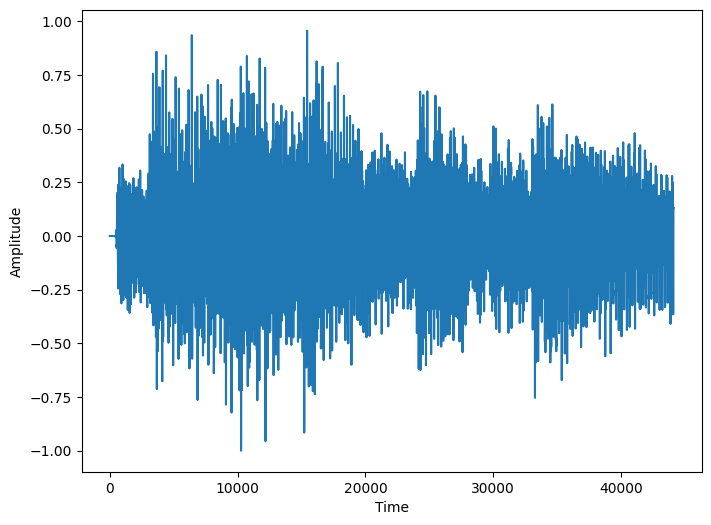

In [121]:
fig = plt.figure(figsize=(8,6))
plt.plot(x)
plt.xlabel("Time")
plt.ylabel("Amplitude");

Мы изобразили, как меняется амплитуда волны в зависимости от времени. Из школьного курса физики вы можете вспомнить, что может быть очень полезно смотреть и на частоты. Для этого воспользуемся дискретным косинусным преобразованием, из предыдущего раздела.

1. Используя `scipy.fft.dct` вычислите вектор частот $D_n x$, где $x$ - исходная дорожка. В каком промежутку сконцентрированы частоты?

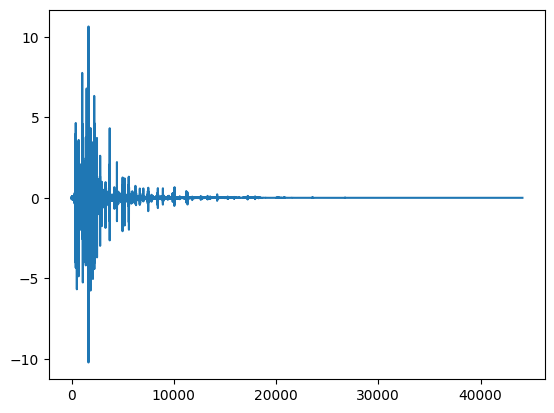

In [122]:
w = scipy.fft.dct(x,norm = 'ortho')
plt.plot(w)
plt.show()

Частоты сконцентрированы в промежутке от 0 до 10000

В пункте (с) мы с использованием ДКП постараемся восстановить двухмерное изображение по значениям в небольшом числе пикселей. Чтобы облегчить решение двухмерной части мы сначала мотивируем действия на примере одномерной звуковой дорожки: будем хранить случайно выбранные 10% координат $w$, и обсудим, как по ним можно бы было восстановить исходную дорожку.

Говоря формально: построим матрицу $P \in \mathbb{R}^{m \times n}, m = \lfloor 0.1  n \rfloor$, причем в каждой строке и каждом столбце $P$ встречается ровно 1 единица, остальные значения равны 0. То есть $P$ - обрезанная матрица перестановки.

In [123]:
n = x.shape[0]
m = int(0.1 * n)
idxs = np.random.choice(n, m, replace=False)
P = np.zeros((m,n))
P[np.arange(m), idxs] = np.ones(m)
y = P @ x

Таким образом имеем:
\begin{align*}
    y = &Px\\
    s = &D_n x\\
    y = &PD_n^T s
\end{align*}

Можно как восстанавливать $x$ напрямую через $y$, так и решить сначала восстановить частоты $s$, а по ним однозначно получить $x$ через обратное ДКП.

2. Как известно, псевдообратная матрица даёт лучшее по 2 норме решение. Вычислите $x_{pinv}=P^{+}y$ за O(mn). Распишите координаты $x_{pinv}$ и объясните почему такое решение не помогает с восстановлением $x$.

$P = U\Sigma V^{T}$ - SVD
$\\ P^{+} = V\Sigma^{+}U^{T}\\$
В матрице P ортонормированные строки $\Rightarrow PP^{T} = I = U\Sigma^2U^{T}\\$
$P^{+} = P^{+}PP^{T} = V\Sigma U^{T} = P^{T}$ 
$x_{pinv} = P^{T}y\\$
Так как $y$ имеет длину m, а $R^{T}$ имеет размер $n\times m$ поэтому умножение за $O(mn)$

In [124]:
x_pinv = P.T @ y

**Ваше объяснение:** 
$x_{pinv}[i]= (P^{(i)})^{T}y\\$
Столбец $P^{(i)}$ либо нулевой, если i-ый элемент вектора x не оказался в векторе y, или стоит единственная 1 (остальные 0), на месте элемента, куда в процессе перестановки переставили $x_{i}\\$
Поэтому в $x_{pinv}$ элементы, участвующие в перестановке вернутся на свои места, а на остальных местах будут 0, то есть информацию об "обрезанных" индексах мы не получим, поэтому такое решение не помогает с восстановлением x

3. Постройте график $D_nx_{pinv}$, сравните с графиком частот исходной волны. Чем они отличаются?

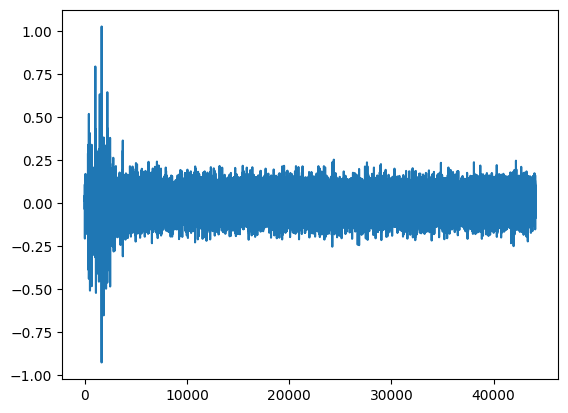

In [125]:
w = scipy.fft.dct(x_pinv,norm = 'ortho')
plt.plot(w)
plt.show()

Коэффициенты не затухают даже на очень высоких частотах, в отличие от предыдущего графика

Теперь попробуем подойти к восстановлению изображения с другой стороны: будем решать при фиксированном $\mu > 0$ так называемую $\ell_2$-регуляризованную задачу наименьших квадратов (в англоязычной литературе ridge regression):

$$
\|Px - y\|_2^2 + \mu \|x\|_2^2 \to \min
$$

Смысл состоит в том, что мы хотим, чтобы одновременно и $x$ давала проекцию, похожую на $y$, и при этом сам вектор $x$ не был слишком велик по норме.

Для решения этой задачи запишем условие равенства нулю градиента этой функции:

$$
2(Px-y)^\top P + 2\mu x^\top = 0 \Leftrightarrow (P^\top P + \mu I)x = P^\top y.
$$


4. Объясните, почему в нашем случае не имеет смысла применять Ridge для восстановления исходного вектора (как решая относительно x, так и относительно s).

**Ваше решение:** 
1. Относительно x:
$(P^{T}P + \mu I)x = x_{pinv}\\$
$P^{T}P$ - матрица Грама системы столбцов матрицы P, у всех столбцов единицы стоят в разных местах, соответственно эта матрица диагональна, те столбцы матрицы P, которые соответствуют элементам x, не вошедшие в вектор y, нулевые, норма остальных = 1, следовательно $P^{T}P$ - диагональная матрица с $p_{ii} = 1$, если элемент i вошел в y, и 0 иначе.
$\\(P^{T}P + \mu I) = A$ - диагональная матрица с $a_{ii} = 1+\mu$, если элемент i вошел в y, и $\mu$ иначе
$Ax = x_{pinv}$ в таком случае 
$\\ x_i = \frac{1}{1+\mu}x_{pinv}$, если i-ый элемент вектора x вошел в y, то есть полученный коэффициент вектора - это реальный коэффициент вектора x домноженный на коэффициент
$\\ x_i = 0$ если i-ый элемент вектора x не вошел в у$\\$
Таким образом, мы опять не получили никакой информации о пропущенной части вектора x
2. Относительно s:
$\\ (D_nP^{T}PD_n^{T} + \mu I)s = D_n x_{pinv}\\$ 
так как $\;D_nD_n^{T} = I\\$
$D_n(P^{T}P + \mu I)D_n^{T}s = D_n x_{pinv}\\$
$D_n^{T}s = A^{-1}x_{pinv}\\$
$s = D_n A^{-1} x_{pinv}\\$
Теперь восстановим x из s
$\\ x = D_n^{T}s = A^{-1} x_{pinv}\\$
Результат аналогичен пункту 1


5. Вычислите матрицу $A = PD_n^T$ с помощью `scipy.fft.dct`. Не используйте транспонирование, ваш алгоритм должен быть сложности O(mn log n).

У функции scipy.fft.dct есть параметр axis, вдоль этой заданной оси и происходит преобразование векторов, то есть если мы передадим этой функции матрицу P $\\$и установим axis = 1, в таком случае преобразования будут происходить со строками и будут укладываться в строки, то есть будет посчитано $\;(D_nP^T)^T = PD_n^T = A\\$
В таком случае мы должны будем вычислить преобразование для m векторов размера n (так как размер P - $m\times n$), преобразование одного вектора можно выполнить за $O(nlogn)$. Тогда итоговая асимптотика $O(mnlogn)$

In [126]:
A = scipy.fft.dct(P,axis = 1,norm = 'ortho')

Интерпретация с частотами звуковой волной позволяет получить хорошую интуицию насчет ДКП: для массивов встречающихся в реальности вектор в пространстве частот будет близок к разреженному, то есть содержащему большое число нулей. В следующем разделе мы воспользуемся этим фактом для более умного метода восстановления входного массива, но на этот раз в двумерном случае.

### c. Двумерный случай (изображение)

Рассмотрим [фотографию](https://en.wikipedia.org/wiki/Deconvolution) лунного кратера.

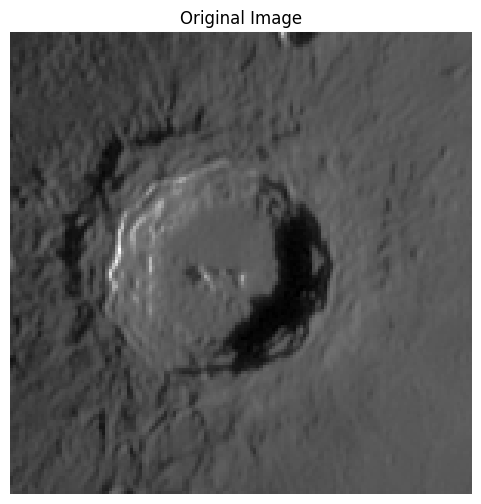

In [127]:
img = plt.imread("data/crater.png").astype(float)
X = img.mean(axis=2)
X -= X.mean()
X = X / np.abs(X).max()

plt.figure(figsize=(6,6))
plt.imshow(X, cmap="gray");
plt.axis("off")
plt.title("Original Image");

Занулим 80% всех пикселей.

In [128]:
n = X.shape[0]
m = int(0.2 * n*n)
idxs = np.random.choice(n*n, m, replace=False)

P = np.zeros((m,n*n))
P[np.arange(m), idxs] = np.ones(m)
y = P @ X.reshape(-1)

1. С помощью P постройте картинку исходного размера, где эти пиксели занулены:

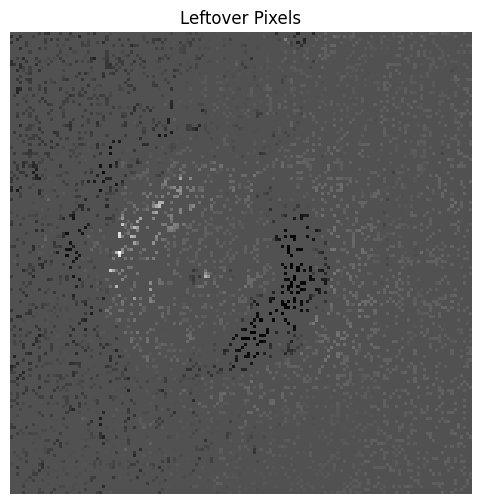

In [129]:
sparsed_X = (P.T @ y).reshape((n,n))

plt.figure(figsize=(6,6))
plt.imshow(sparsed_X, cmap="gray");
plt.axis("off")
plt.title("Leftover Pixels");

Если вы всё сделали правильно, то большяа часть картинки будет серой. Понятно, что по такому небольшому числу пискселей вряд ли получится восстановить детали изображения, но общие очертания мы получить все же сможем.

Для двумерных изображений нужно применять уже 2d дискретное косинусное преобразование (1d на векторизованной картинке потеряет вертикальную близость между пикселями -- можете попробовать).

Пусть $X \in \mathbb{R}^{n \times n}$ - исходное изображение. Тогда двумерным дискретным косинусным преобразованием будет:

$$
    S = D_n X D_n^T
$$

2. С помощью `scipy.fft.dct` постройте матрицу $S$ и изобразите её. Ваше решение должно быть сложности $O(n^2 \log n)$. Можно ли и в двумерном случае говорить о разреженности частот?

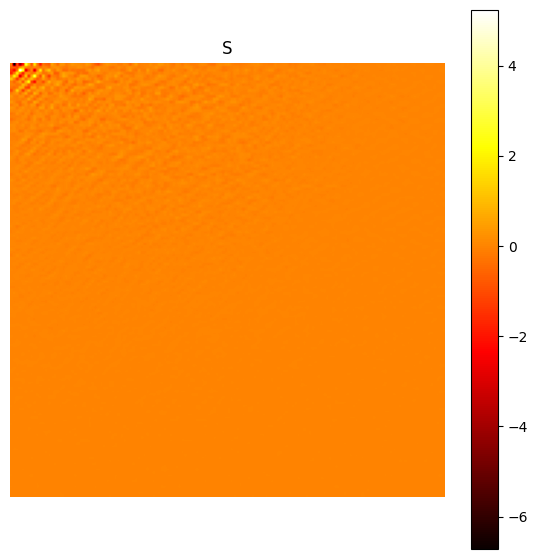

In [130]:
plt.figure(figsize=(7,7))
plt.axis("off")
S = scipy.fft.dct(scipy.fft.dct(X,axis = 0,norm = 'ortho'),axis = 1,norm = 'ortho')
plt.imshow(S, cmap="hot")
plt.colorbar()
plt.title("S");

Дискретное косинусное преобразование работает за $O(nlogn)$, в данном случае нам надо проделать дкп с n векторами, и потом с получившейся матрицей проделать еще раз дкп с n векторами, итого общая сложность $O(n^2logn)$

Да, тут тоже можно говорить о разреженности частот, так как в полученных коэффициентах совсем немного ненулевых значений, которые соответствуют близким ячейкам с маленьким индексом, то есть так как в формуле для получения $s_{pq}$ мы должны умножать элементы $x_{ij}$ на косинусы вида $cos(pa)*cos(qb)$, где a и b изменяются, так как $cos(pa)*cos(qb) = 0.5(cos(pa + qb) + cos(pa-qb))$, следовательно так как для реальных объектов будут характерны низкие частоты, то ненулевые коэффициенты будут в левом верхнем углу

То есть:

$$
    vec(S) = (D_n \otimes D_n) vec(X)
$$

Нам известно наблюдение $Y \in \mathbb{R}^{m \times m}$ с зануленными координатами:

$$
    vec(Y) = P vec(X)
$$

Выражение $Y$ через $S$ примет вид:

$$
    vec(Y) = \underbrace{P (D_n \otimes D_n)^{T}}_{A} vec(S)
$$

2. Используя `scipy.fft.dct` и `scipy.fft.idct` постройте матрицу A. Ваше решение должно быть сложности $O(m^2n^2 \log n)$.

**Подсказка:** Для этого посмотрите как матрица $(D_n \otimes D_n)$ действует на каждую строку матрицы $P$ (или столбец матрицы $P^T$). Вам пригодится трехмерный `np.reshape`.

**Ваш вывод формулы:** 
$P(D_n \otimes D_n)^T = ((D_n \otimes D_n)P^T)^T\\$
Столбцы матрицы $P^T$ - это векторы с единственным ненулевым (единичным) элементом, который соответствует картинке, в которой оставлен только 1 пиксель. 
$\\(D_n \otimes D_n)p^T_i = vec(D_nX_{one\;pixel}^TD_n^T)$ - то есть это двумерное косинусное преобразование транспонированной изначальной картинки, в которой оставили всего 1 пиксель. $vec(D_nX_{one\;pixel}^TD_n^T) = vec(D_n(D_nX_{one\;pixel})^T) = vec_{по\;строкам}(D_nX_{one\;pixel}D_n^T)$
Двумерное косинусное преобразование картинки происходит за $O(n^2logn)$, такие преобразования нужно будет сделать с каждым столбцом матрицы P^T, то есть 
итоговая сложность $O(mn^2logn)$

То есть мы должны каждую строку матрицы P развернуть в картинку, то есть получить матрицу размером (m,n,n), далее к каждой матрице (n,n) нужно будет применить двумерное дкп,и после опять свернуть в двумерную матрицу размера (m,n*n)

In [131]:
A = np.transpose(scipy.fft.dct(scipy.fft.dct(P.reshape((m,n,n)),axis = 1,norm = 'ortho'),axis = 2,norm = 'ortho'),(0,2,1))
A = A.reshape((m,n*n))

**Lasso**

Если в ridge regression вместо квадрата второй нормы $x$ использовать первую норму (то есть ставить $\ell_1$-регуляризованную задачу наименьших квадратов), то получится такая задача минимизации:
$$
\|Avec(S)-vec(Y)\|_2^2 + \mu \|vec(S)\|_1 \to \min.
$$

Такая задача оказывается более подходящей в нашем случае, так как её решение часто оказывается близким к разреженному (получить некоторую интуицию о том, почему так происходит, можно, например, [тут](https://medium.com/analytics-vidhya/intuition-behind-l1-l2-regularisation-2ac1e6a1bd81); более развёрнутое описание метода есть в [википедии](https://en.wikipedia.org/wiki/Lasso_(statistics))).

Однако разреженность исходной картинки $vec(X)$ вряд ли нам поможет. Вместо этого будем решать Lasso относительно $vec(S)$: ведь для частотного представления мы наблюдали разреженность.

5. Заполните пропуски в функции *solve_lasso*. Примените её для решения $y = As$. По полученному решению восстановите вектор $x$ с помощью `scipy.fft.idct`. 

**Подсказка:** Воспользуйтесь [документацией sklearn.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)


In [132]:
from sklearn.linear_model import Lasso

def solve_lasso(A, y):
    lasso = Lasso(alpha=1e-6)
    s = lasso.fit(A,y).coef_
    return s

In [133]:
vec_s = solve_lasso(A, y)
X_reconstructed = scipy.fft.idct(scipy.fft.idct(vec_s.reshape((n,n),order = 'f'),axis = 0,norm = 'ortho'),axis = 1,norm = 'ortho')

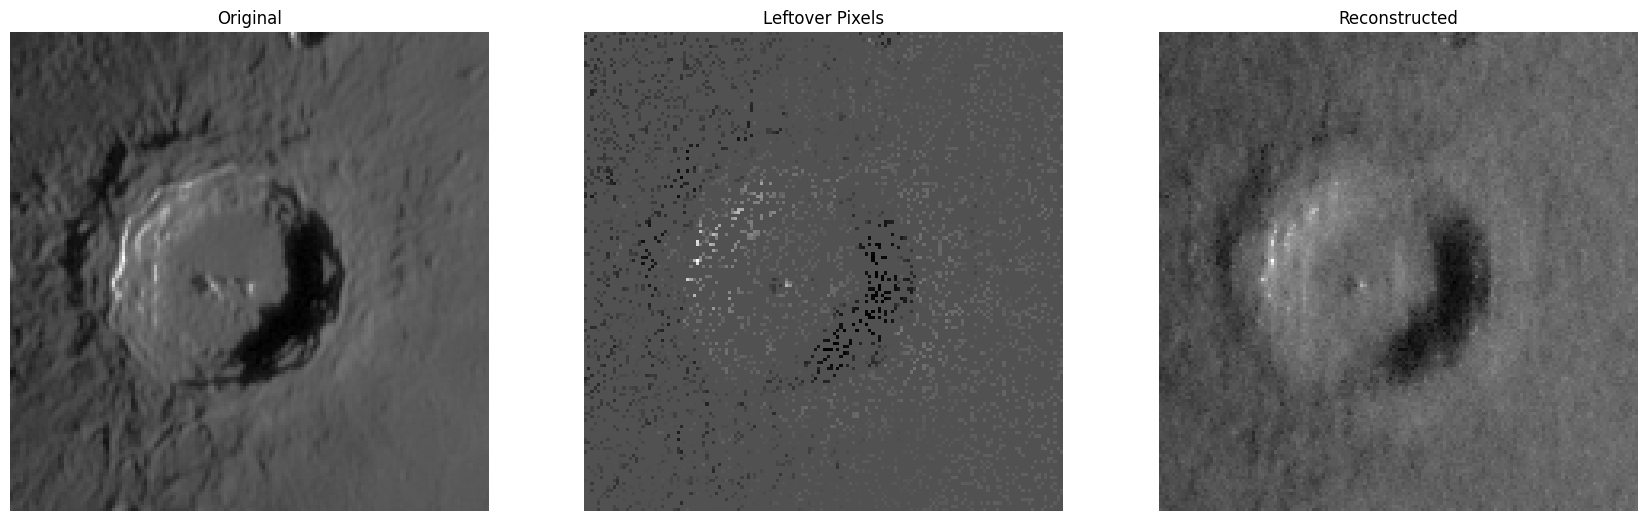

In [134]:
fig, axs = plt.subplots(figsize=(21, 7), ncols=3)
axs[0].imshow(X, cmap="gray")
axs[0].set(title="Original")
axs[0].axis("off")
axs[1].imshow((P.T @ y).reshape(n,n), cmap="gray")
axs[1].set(title="Leftover Pixels")
axs[1].axis("off")
axs[2].imshow(X_reconstructed, cmap="gray")
axs[2].set(title="Reconstructed")
axs[2].axis("off");

# Задача 2. Дискретная свертка и ее обращение

В этой задаче мы научимся эффективно вычислять **свёртку** изображения на примере одного из самых известных фильтров &mdash; фильтра Гаусса (подзадачи a., b., c.), а также попробуем восстановить исходное изображение из размытого (подзадача d.).

Начнем с эффективного применение фильтра Гаусса

Загрузим изображение (в виде матрицы $A$), с которым будем работать. Будем использовать одну из классических фотографий, применяемых для тестирования алгоритмов обработки изображений: "cameraman". 

/tmp/ipykernel_21572/3965383068.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A = imread('data/cameraman.tif').astype(np.float)


(256, 256)


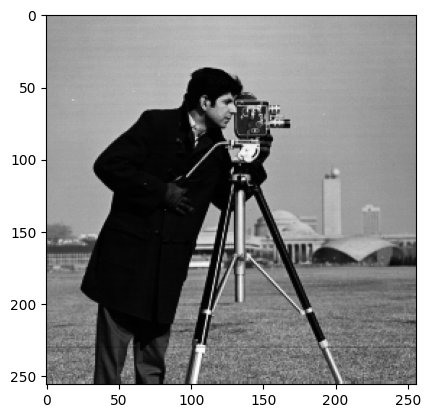

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

A = imread('data/cameraman.tif').astype(np.float)
print(A.shape)
_ = plt.imshow(A, cmap='gray')

Мы будем учиться применять к картинке [фильтр Гаусса](https://en.wikipedia.org/wiki/Gaussian_blur), чтобы получить в итоге что-то вроде следующего изображения. 

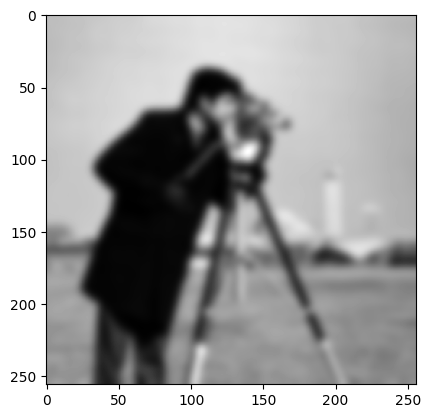

In [136]:
from scipy.ndimage import gaussian_filter
B = gaussian_filter(A, 3)
_ = plt.imshow(B, cmap='gray')

### a. Формулировка задачи

При это преобразовании каждый пиксель картинки заменяется на взвешенную сумму соседних пикселей (вообще говоря, всех остальных пикселей картинки), причём вес пикселя со смещением $\Delta x$ и $\Delta y$ относительно данного есть
$$
G(\Delta x, \Delta y) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\Delta x^2 + \Delta y^2}{2\sigma^2}\right).
$$
Это называется двумерной **свёрткой** картинки с фильтром Гаусса (обычно при этом считается, что картинка продолжена за края каким-то образом, например, отражена, чтобы пиксели размытой картинки у краёв не имели меньшую яркость. Но мы не будем реализовывать этот эффект).

 1. Покажите, что результат $B$ применения такой операции к матрице $A$ можно представить в виде
$$
    B = T_m A T_n^T,
$$
где 
$$
(T_n)_{i,j} = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(i-j)^2}{2\sigma^2}\right).
$$

**Замечание:** формулу для $B$ можно будет использовать в дальнейшем даже если этот пункт не был решен.

$B_{ij} = \sum_{t = 1}^{m}tm_{it}(AT_n^T)_{tj} = \sum_{t = 1}^{m}tm_{it}\sum_{v=1}^{n}a_{tv}tn_{jv} =  \sum_{t = 1}^{m}\frac{1}{\sqrt{2\pi \sigma^2}} exp \left(-\frac{(i-t)^2}{2\sigma^2}\right)\sum_{v=1}^{n}a_{tv}\frac{1}{\sqrt{2\pi \sigma^2}} exp \left(-\frac{(j-v)^2}{2\sigma^2}\right) = \frac{1}{2\pi \sigma^2}\sum_{t = 1}^{m}\sum_{v=1}^{n}a_{tv} exp \left(-\frac{(i-t)^2 + (j-v)^2}{2\sigma^2}\right) = \frac{1}{2\pi \sigma^2}\sum_{\Delta i = i-m}^{i-1}\sum_{\Delta j=j-n}^{j-1}a_{(i - \Delta i)(j - \Delta j)} exp \left(-\frac{(\Delta i)^2 + (\Delta j)^2}{2\sigma^2}\right) = \sum_{\Delta i = i-m}^{i-1}\sum_{\Delta j=j-n}^{j-1}a_{(i - \Delta i)(j - \Delta j)} G(\Delta i,\Delta j) $

### b. Имплементация одномерных сверток

1. Реализуйте функцию `convolve_1D`, которая вычисляет $T_m A$ с помощью вложения $T_m$ в циркулянт и использования быстрого преобразования Фурье (```np.fft.fft```). Матрица $T_m$ задаётся с помощью своего первого столбца. При вычислениях нигде не должна возникнуть полная матрица $T_m$.

In [137]:
def convolve_1D(A, T_col):
    """
        Input
            A: m x n matrix
            T_col: array of shape (m,) -- first column of matrix T_m

        Output
            B: m x n matrix, B = T_m @ A
    """
    m = A.shape[0]
    n = A.shape[1]
    v1 = np.fft.fft(np.take(T_col,list(range(m)) + list(reversed(range(1,m))))).reshape(2*m-1,1)
    v2 = np.fft.fft(np.concatenate((A,np.zeros((m-1,n)))), axis = 0)
    ans = np.fft.fft(np.conjugate(v1*v2),axis = 0)[:m,:] * (1/(2*m-1))
    return np.real(ans)

Напишем также функцию `form_T_col`, которая будет создавать первый столбец матрицы `T_m` для заданных параметров `m` и `sigma`, а также `form_T`, которая будет создавать собственно матрицу $T_m$. Мы будем использовать `form_T` для тестирования правильности вычислений.

In [138]:
from scipy.linalg import toeplitz

def form_T_col(m, sigma):
    """
        Input
            m: number of rows of T_m
            sigma: standard deviation of Gaussian filter

        Output
            T_col: array of shape (m,) -- first column of T_m, 
                   the matrix of 1D Gaussian filter
    """
    return 1. / (np.sqrt(2 * np.pi) * sigma) * np.exp((-1. / sigma**2) * np.arange(m)**2)
    
def form_T(m, sigma):
    """
        Input
            m: number of rows of T_m
            sigma: standard deviation of Gaussian filter

        Output
            T_m: m x m matrix of 1D gaussian filter
    """
    return toeplitz(form_T_col(m, sigma))

Теперь мы можем проверить, правильно ли работает функция `convolve_1D`.

In [139]:
B = A[:5,:5]
sigma = 10
m, n = B.shape
T_m_col = form_T_col(m, sigma)
T_m = form_T(m, sigma)
np.linalg.norm(T_m @ B - convolve_1D(B, T_m_col))

2.2469334198890888e-14

2. Используя тот факт, что быстрое преобразование Фурье вектора длины $n$ вычисляется за $O(n\log n)$, выпишите асимптотику времени работы функции `convolve_1D`.

v1  - это БПФ вектора размера m, следовательно это вычисляется за $O(m \log m)\\$
v2 - это БПФ столбцов матрицы размера $(2m-1 \times n)$ это вычисляется за $O(n(2m-1) \log (2m-1)) = O(mn \log (m))\\$
np.conjugate(v1*v2) считается за $O(mn)\\$
БПФ столбцов полученной матрицы считается за $O(n(2m-1) \log (2m-1)) = O(mn \log (m))\\$
умножение на константу и взятие среза считается за $O(mn)\\$
Следовательно асимптотика - $O(mn \log m)$


3. Теперь нам понадобится функция `gauss_convolve_1D`, которая сформирует правильный столбец `T_col` и вызовет `convolve_1D`. Параметр `sigma` соответствует гауссовскому стандартному отклонению $\sigma$ из формулы для $G(\cdot)$.

In [140]:
def gauss_convolve_1D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            B: m x n matrix, B = T_m @ A
    """
    m = A.shape[0]
    return convolve_1D(A,form_T_col(m,sigma))

4. Проверим, как работает наша одномерная свёртка на нашей картинке. Должно быть похоже, что каждый столбец размыли. Когда всё получится, попробуйте поиграть параметром `sigma` и объясните, как от него зависит "сила" размытия.

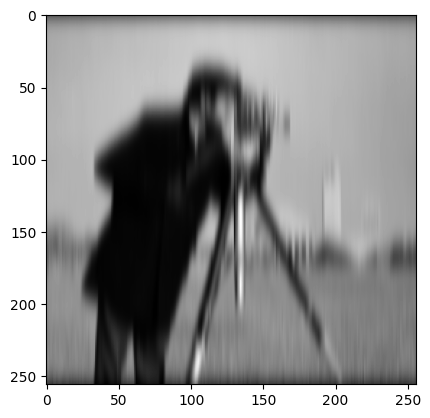

In [141]:
A_conv_1D = gauss_convolve_1D(A, 10)
_ = plt.imshow(A_conv_1D, cmap='gray')

Чем больше дисперсия (стандартное отклонение), тем более размытая получается картинка, так как чем больше дисперсия, тем больше вклад дают дальние элементы, и тем меньше вклада дают близкие

### c. Вычисление двумерной свертки

1. Теперь вы уже без труда сможете написать функцию двумерной свёртки: $B = T_m A T_n^T$, используя функцию ```gauss_convolve_1D```.

In [142]:
def gauss_convolve_2D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            С: m x n matrix, B = T_m @ A @ T_n.T
    """
    return gauss_convolve_1D(gauss_convolve_1D(A,sigma).T,sigma).T

...и визуально проверить, правильно ли она работает.

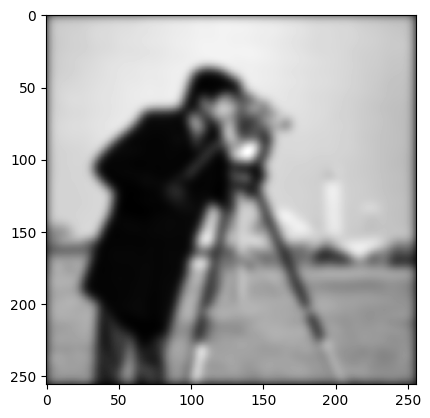

In [143]:
A_conv = gauss_convolve_2D(A, 5)
_ = plt.imshow(A_conv, cmap='gray')

2. Объясните эффект тёмных полос около края картинки.

Темные полосы - это низкое значения яркости этих пикселей, в процессе применения фильтра мы сначала применяем одномерную свертку к столбцам изображения, а потом к строкам, в процессе применения одномерной свертки к каждому столбцу, пиксели в столбце заменяются на взвешенную сумму соседних пикселей, и эти веса зависят от дальности соседнего пикселя, так как у крайних пикселей в каждом столбце нет (или мало) соседей сверху (или снизу), то соответственно значения там меньше, чем у не крайних пикселей, так как веса остаются теми же, соответственно мы получаем меньшую яркость (более черный цвет) у верхнего и нижнего края, аналогично когда мы будем применять одномерную свертку к каждой строке, меньшая яркость будет у пикселей около левой и правой границы, в то же время темные полосы вверху и внизу останутся, так как пиксели в этой полосе заменяются на взвешенную сумму соседних, а все они темные, таким образом мы получаем темные полосы по краям

### d.Обращение свёртки (deconvolution)

Представьте, что к вам попало изображение такого типа.

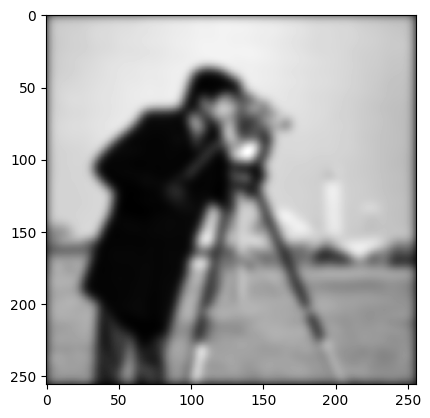

In [144]:
from scipy.ndimage import gaussian_filter
sigma = 5
A_conv = gauss_convolve_2D(A, sigma)
_ = plt.imshow(A_conv, cmap='gray')

Деталей не видно совсем. Чтобы восстановить их попробуем применить применить операцию обратную свертке. 
Мы уже знаем, что размытое изображение $A_{conv}$ вычисляется по формуле $A_{conv} = T_m A T_n^\top$.
Если же матрицы $T_m$ и $T_n$ обратимы, то можно обратить свёртку и получить обратно нашего cameraman:
$$
A = T_m^{-1} A_{conv} T_n^{-\top}.
$$

In [145]:
m, n = A_conv.shape
T_m, T_n = form_T(m, sigma), form_T(n, sigma)
B = np.linalg.solve(T_m, A_conv)
A_rec = np.linalg.solve(T_n, B.T).T

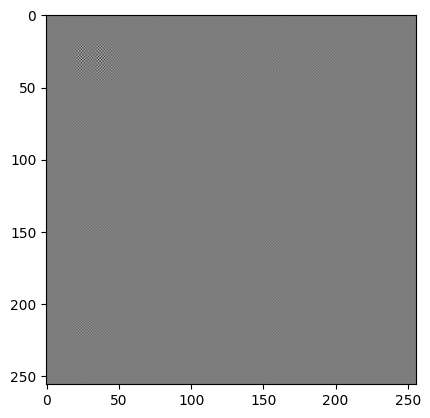

In [146]:
_ = plt.imshow(A_rec, cmap='gray')

Непохоже на исходное изображение. В чём может быть дело?
Давайте выведем сингулярные числа матрицы $G_m$.

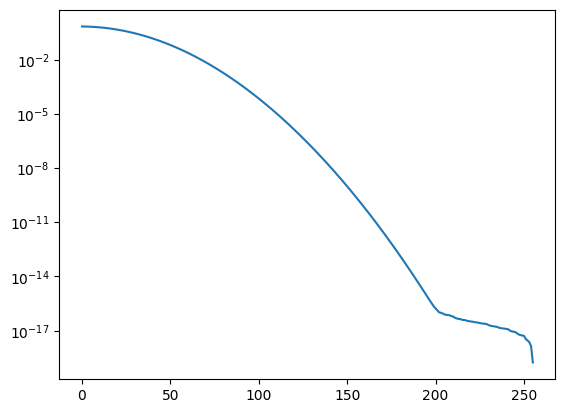

In [147]:
s = np.linalg.svd(T_m, compute_uv=False)
plt.plot(s)
_ = plt.semilogy()

Видно, что у нас большие проблемы , потому что матрица очень близка к вырожденной. Специально для таких матриц у нас есть инструмент псевдообратных матриц, но чтобы оправдать его применение, нужно сначала свести задачу вычисления матрицы $A$ к задаче решения системы линейных уравнений. 
Для этого вспомним формулу, связанную с Кронекеровым произведением: 
$$
\mathrm{vec}(A_{conv}) = (T_n \otimes T_m)\,\mathrm{vec}(A).
$$
Теперь уже можно вычислить "приближённый" $\mathrm{vec}(A)$ с помощью псевдообратных:
$$
\mathrm{vec}(\tilde{A}) = (T_n \otimes T_m)^+ \,\mathrm{vec}(A_{conv})
$$

Конечно, мы не хотим формировать матрицу размеров $mn \times mn$ и работать с ней, поэтому воспользуемся тем фактом, что
$$
(T_n \otimes T_m)^+ = T_n^+ \otimes T_m^+.
$$
Теперь можно перейти обратно к матричной записи: 
$$
\tilde{A} = T_m^+ A_{conv} (T_n^+)^\top.
$$

1. Напишите функцию `pseudoinverse`, вычисляющую для заданной матрицы $P$ сингулярное разложение её $\delta$-псевдообратной.
Необходимо вернуть компактное SVD матрицы $P^+_\delta$.
Для вычисления используйте сингулярное разложение матрицы $P$. Использовать функцию `np.linalg.pinv` запрещено.

In [148]:
def pseudoinverse_svd(P, threshold=1e-15):
    """
        Input
            A: m x n array
            threshold: smaller singular values are to be dropped
        Output
            U: n x r array with orthonormal columns
            S: array of size r
            VT: r x m array with orthonormal rows
    """
    U,E,VT = s = np.linalg.svd(P, full_matrices = False)
    E = E[E >= threshold]
    r = len(E)
    VT = VT[:r,:]
    U = U[:,:r]
    return VT.T, 1/E, U.T

Проверим, что псевдообратная совпадает с обратной для квадратной невырожденной матрицы $A$ (случайная матрица с вероятностью, очень близкой к единице, является невырожденной).

In [149]:
A1 = np.random.random((3, 3))
U, S, VT = pseudoinverse_svd(A1)
pinv = np.multiply(U, S) @ VT
assert np.linalg.norm(pinv @ A1 - np.eye(3)) < 1e-12

2. Реализуйте функцию ```inverse_gauss_convolve_2D```, которая реконструирует изображение по "смазанной" картинке $A_{conv}$ с помощью псевдообратных матриц от матриц $T_m$ и $T_n$, у которых занулили сингулярные числа меньше ```tol```. **Замечание:** В данном случае ```np.linalg.pinv``` выдаст всю псевдообратную матрицу, что подойдет в качестве решения. Но можно сделать немного эффективнее, если явно умножать на компоненты компактного SVD.

In [150]:
def inverse_gauss_convolve_2D(A_conv, sigma, tol):
    """
        Input
            conv: m x n matrix -- result of convolution with
                  a Gaussian filter
            sigma: standard deviation of Gaussian filter
            tol: absolute tolerance for cutting singular values in pseudoinverse

        Output
            A_rec: m x n reconstructed matrix, such that approximately A_conv = T_m @ A_rec @ T_n.T
    """
    U1,S1,VT1 = pseudoinverse_svd(form_T(A_conv.shape[0],sigma),tol)
    U2,S2,VT2 = pseudoinverse_svd(form_T(A_conv.shape[1],sigma),tol)
    return U1 @ (np.diag(S1)@(VT1 @ A_conv @ VT2.T)@ np.diag(S2)) @ U2.T

Посмотрим на получившийся результат.

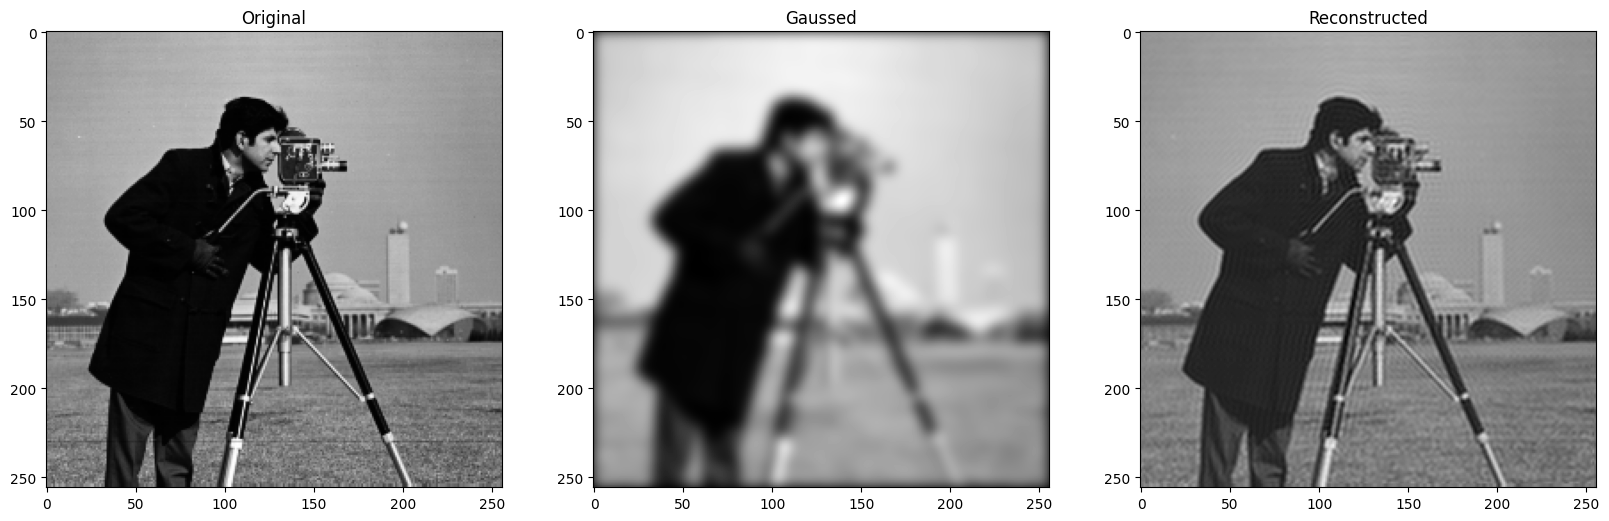

In [151]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow(A, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(A_conv, cmap='gray')
axs[1].set_title("Gaussed")
A_rec = inverse_gauss_convolve_2D(A_conv, sigma, 1e-8)
axs[2].imshow(A_rec, cmap='gray')
_ = axs[2].set_title("Reconstructed")